In [2]:
import dask.dataframe as dd
from nltk.corpus import stopwords
import nltk
import re
import pandas as pd
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from dask.diagnostics import ProgressBar
%matplotlib inline
import seaborn as sns
import ast
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.utils import simple_preprocess
from src.utils.helpers_news_movies import *
from collections import defaultdict
from scipy.sparse import csr_matrix
from scipy.signal import correlate
from IPython.display import Image

import plotly.express as px
import plotly.graph_objects as go

# Import code from other files
from src.utils import helpers_temporality_analysis as hta

In [3]:
from src.utils.helpers_sentiment_analysis import *
from src.utils.helpers_temporality_analysis import *
from src.utils.helpers_movies_genres import *
from src.utils.helpers_movies import *
from src.utils.helpers_news import *
from IPython.display import Image

In [4]:
# Load the data

movies_summaries = pd.read_csv('data/MovieSummaries/movies_metadata_cleaned.csv')
# Keep only the columns we need : 'Wikipedia_movie_ID' 'Plot_summary' and 'Movie_release_date'
movies_summaries = movies_summaries[['Wikipedia_movie_ID', 'Plot_summary', 'Movie_release_date']]
# Rename the columns
movies_summaries.columns = ['ID', 'processed_text', 'year']
news_articles = pd.read_csv('data/NewsArticles/nyt_processed_data.csv')
# Rename the unnamed column to 'ID'
news_articles.rename(columns={'Unnamed: 0': 'ID'}, inplace=True)


print(movies_summaries.head())
print(news_articles.head())

plaintext_movies_df = pd.read_csv('data/MovieSummaries/plot_summaries.txt', sep="\t", header=None)
plaintext_movies_df.columns = ['ID', 'plaintext']
plaintext_news_df =  dd.read_parquet('data/nyt_data.parquet')
plaintext_news_df.columns = ['year', 'title', 'plaintext']
# Add the ID column
plaintext_news_df['ID'] = range(plaintext_news_df.shape[0].compute())
# Convert to pandas
plaintext_news_df = plaintext_news_df[['ID', 'year', 'title', 'plaintext']].compute()

print(plaintext_movies_df.head())
print(plaintext_news_df.head())



         ID                                     processed_text    year
0    975900  Set second half 22nd century film depicts Mars...  2001.0
1   9363483  series murders rich young women throughout Ari...  1987.0
2    261236  Eva upper class housewife becomes frustrated l...  1983.0
3  18998739  Every hundred years evil Morgana returns claim...  2002.0
4   6631279  Adam San Franciscobased artist works cab drive...  1997.0
         ID  year                                     processed_text
0  13355234  1992  french observed anniversary today first major ...
1   4220746  1941  race josephs overtakes randolph midget auto ev...
2  11058934  1974  penn central sues govt million charging adopti...
3  12915396  1989  lead company reports trinity industries nyse s...
4  10134262  1968  felder kirp found dead upper manhattan police ...
         ID                                          plaintext
0  23890098  Shlykov, a hard-working taxi driver and Lyosha...
1  31186339  The nation of Panem c

# Results Presentation

This notebook's purpose is to show the methods we used to extract meaning from our data, and present global results. We invite you to head over to LINK to dive deeper in the result's analysis and explanation. 

## Natural Language Processing techniques

For all text processing, we used the python package SentenceTansformers (also know as SBERT). This allowed us to load a pre-trained model (in particular, the "all-MiniLM-L6-v2" model) to transform texts like movie plot summaries and news article into a vector reprensatation (called "embedding). 

This method is has the advantage of leveraging a powerfull vector representation of words and text, that would be impossible to replicate given that our data is very noisy. A lot of movie plot summaries are empty or contain information useless to our analysis (like only containing names of characters and actors). This noise made approaches based on our data alone (like LDA) perform poorly. Moreover, our method only requires to compute the embedding of each document, which is done with linear time. Other approaches often require the TF-IDF matrix, which is too expensive to compute on our large dataset. 

Both movie plot summaries and news article are processed and converted to a vector embedding in the notebooks "Find_movies.ipynb" and "Find_news.ipynb". These embeddings are then saved in npy format. This computation take around 30 minutes on a recent computer with GPU-acceleration.

## Theme queries and similarity

The themes we kept for the final analysis are the following : 

- Vietnam War
- Cold War
- World War II
- Technology
- Health
- Gender Equality

These themes were determined through manual examination of the results when trying different querries. 

We found that the most interesting results came from the simplest querries. We thus used the following querries to represent our themes: 

- Vietnam War : "Vietnam"
- Cold War : "USSR"
- World War II : "World War 2"
- Technology : "technology"
- Health : "health"
- Gender Equality : "gender equality"

We then converted these querries to their enbeddings, and computed the cosine similarity between each movie (or news article) and each querry. This result was then saved to a CSV file, to load as a dataframe. 

This is also done in the "Find_news" and "Find_movies" notebooks.

In [5]:
# Load cosine similarity dataframes
cosine_similarity_news_df = pd.read_csv('data/df_news/cosine_similarity_news.csv')
# Rename the unnamed column to 'ID'
cosine_similarity_news_df.rename(columns={'Unnamed: 0': 'ID'}, inplace=True)
cosine_similarity_movies_df = pd.read_csv('data/df_movies/cosine_similarity_movies.csv')
# Rename the index column to 'ID'
cosine_similarity_movies_df.rename(columns={'index': 'ID'}, inplace=True)
# Set the index to 'ID'
cosine_similarity_movies_df.set_index('ID', inplace=True)
cosine_similarity_news_df.set_index('ID', inplace=True)

themes = ['vietnam', 'cold_war', 'irak_war', 'ww2', 'technology', 'economy', 'health', 'gender_equality', 'migration']

# Example : Find the movie and news article with the highest cosine similarity for the theme 'Cold War'
theme = 'technology'
movie_id = cosine_similarity_movies_df[theme].idxmax()
news_id = cosine_similarity_news_df[theme].idxmax()

movie_text = plaintext_movies_df.get(plaintext_movies_df['ID'] == movie_id)['plaintext'].values[0]
news_text = plaintext_news_df.loc[news_id]['title'] + ' ' + plaintext_news_df.loc[news_id]['plaintext']

print('Theme :', theme)
print('Movie :')
print(movie_text)
print('News :')
print(news_text)
print('---------------------------------------')




Theme : technology
Movie :
In the near future, a technology enabling time travel has been developed and is now in commercial use. A group of aging former Nazis conspires to alter the results of the Second World War by traveling back in time and supplying Adolf Hitler with a hydrogen bomb. To this end, they bribe the corrupt time machine pilot Karel, who agrees to assist them. On the day of the scheduled journey, Karel chokes on a croissant and dies. His identical twin brother, Jan, cannot bring himself to tell Karel's fiancée Eva and begins to impersonate Karl. He is also later mistaken for Karel by the Nazis and stumbles along with their plot. Having been a designer of the rocket-ship time machine, he is able to pilot the ship and take them all back in time. When he realizes the nature of the Nazis' plans, Jan resolves to prevent their success. After triggering several paradoxes by travelling back and forth in time, he manages to defeat the Nazis and resolve the consequences of his tw

These 2 documents do indeed talk about technology, which indicates the cosine similarity makes interesting links between the themes and the contents of movie descriptions and news articles. 

We then use an arbitrary treshold to determine if a movie or news article "talks about" a certain theme. Let us try to display a few movies summaries and news article refereing to technology according to this criterion : 

In [6]:
# Convert cosine similarity to bool with threshold of 0.3

cosine_similarity_news_df_bool = cosine_similarity_news_df.copy()
cosine_similarity_movies_df_bool = cosine_similarity_movies_df.copy()

for theme in themes:
    cosine_similarity_news_df_bool[theme] = cosine_similarity_news_df_bool[theme].apply(lambda x: 1 if x > 0.3 else 0)
    cosine_similarity_movies_df_bool[theme] = cosine_similarity_movies_df_bool[theme].apply(lambda x: 1 if x > 0.3 else 0)

# Get 5 movies with cosine similarity above 0.2 to the theme

theme = 'cold_war'
movies = cosine_similarity_movies_df_bool[cosine_similarity_movies_df_bool[theme] == 1].index
for movie in movies[:5]:
    print('Movie :', movie)
    print(plaintext_movies_df.get(plaintext_movies_df['ID'] == movie)['plaintext'].values[0])
    print('---------------------------------------')

# Get 5 news articles with cosine similarity above 0.2 to the theme
theme = 'cold_war'
news = cosine_similarity_news_df_bool[cosine_similarity_news_df_bool[theme] == 1].index
for news_id in news[:5]:
    print('News :', news_id)
    print(plaintext_news_df.loc[news_id]['title'] + ' ' + plaintext_news_df.loc[news_id]['plaintext'])
    print('---------------------------------------')


Movie : 27997130
Three young Russians from very different walks of life involutarily enter the military to escape their past.
---------------------------------------
Movie : 30413149
Set in the 1970s in South Korea under the rule of Park Chung-hee's dictatorship when indie rock band Devils led by Sang-kyu and his five members becomes famous after they perform at a U.S. military base and Go-Go clubs. They also hire female singer Mimi, who becomes a fashion icon, but they face their trials when they lose a band member who was killed by fire at the club and forced break-up due to military dictatorship, but Sang-kyu plans to come back for his band members in concert again called Devils Recital.
---------------------------------------
Movie : 4105119
In the Soviet Union, American reporter McKinley "Mac" Thompson  secretly writes unflattering stories, attributed to "Comrade X", for his newspaper. His identity is discovered by his valet, Vanya , who blackmails Mac into promising to get his da

Though there is some noise in this method, we can see that most of the printed documents are related to the Cold War, Russia and USSR theme. This binary classification now lets us count the frequency at which each of our selected themes appear in time. We can now analyse the theme popularity across time and look for correlations between themes depicted in movies and those in news articles. 

# Theme occurence frequency and cross-correlation analysis
We'll take two theme to show how we computed the cross-correlation. All the other plots can be found in `src/sentiment_analysis/{theme}_Sentiment_Analysis.ipynb`

The above method computes the cross-correlation between the frequency of appearance in movies and in news articles for a given theme. It then produces 2 plots: 

- The first one showing if there is a correlation between the 2 distributions, and shows how this correlation evolves when shifting one of the distribution in time. In other words, if there is a correlation between the two distributions with 0 shift, this means the 2 themes have a similar frequancy distribution. If there is a "lag" for which we can show a strong correlation, that means the theme's popularity has a similar evolution on both mediums but with one being late relative to the other one. 

- The second one showing the 2 frequency distributions , either aligned in time or with the theme's distribution in the news shifted by the previously computed optimal "lag. 

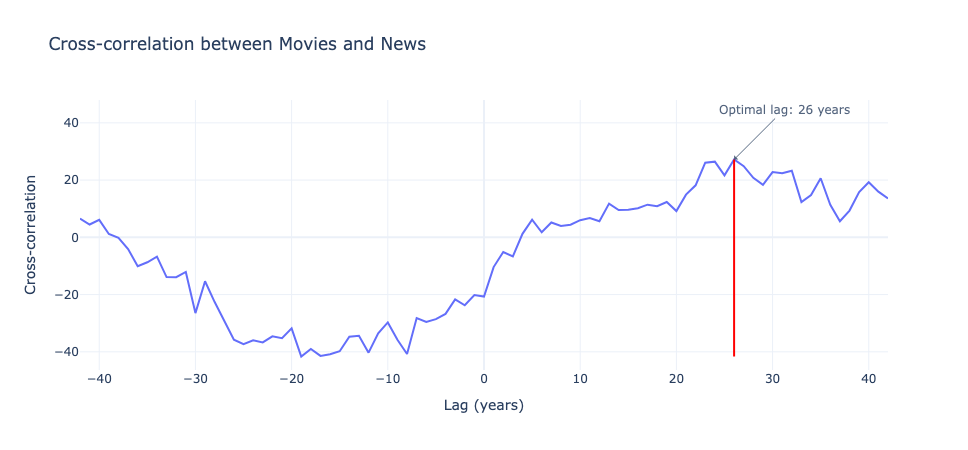

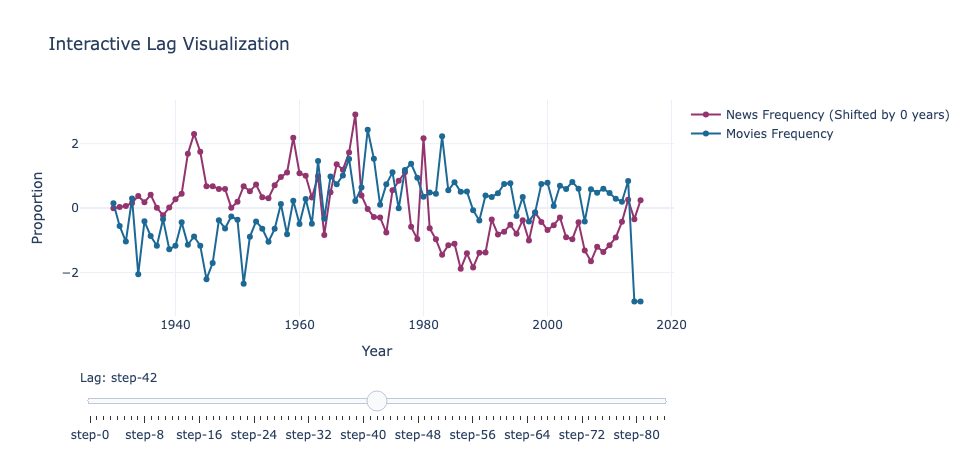

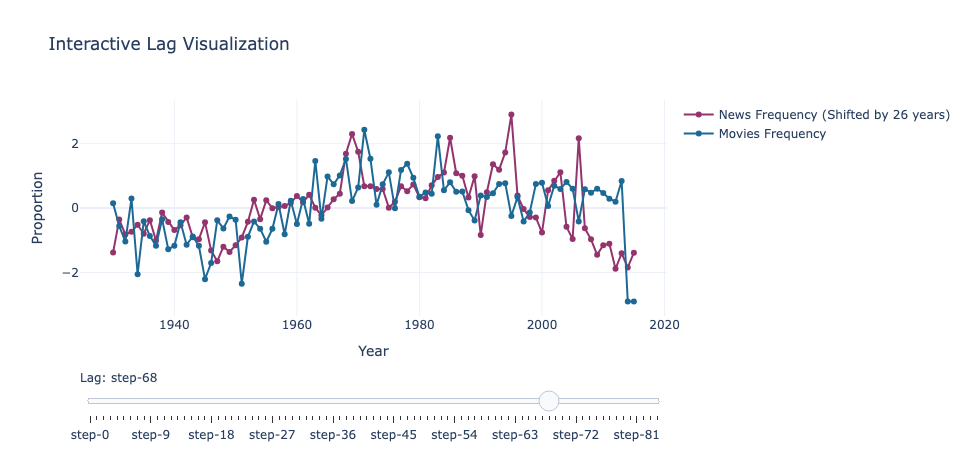

In [7]:
theme = 'Gender Equality'
# This line is commented because we cannot show interactive plots on the HTML export.
#hta.plot_movies_and_news_frequency(theme, 'data/')

# We load saved versions of the interactive plots instead. 
plot_1 = Image(filename='figures/saved_plots_results/cross-corr.png')
plot_2 = Image(filename='figures/saved_plots_results/distrib-normal.png')
plot_3 = Image(filename='figures/saved_plots_results/distrib-shifted.png')

display(plot_1)
display(plot_2)
display(plot_3)

This surprising results shows that the frequency at which the theme 'Gender Equality' appears in news and movies with a similar evolution pattern, but with a 26 years time difference. This number could indicate that news and movies conform to different generations. This comes as a surprise for us, as we expected the film industry to react more slowly than the news to evolution of our societies. 

However, a lot of movies from the dataset are small independently produced movies. This could explain why, on the contrary, movie themes are greatly in advance of their news counterparts: small independent artists could tend to be visionnary, whereas the mainstream news and media talk more about maintream topics, reducing the relative frequency of niche topics. 

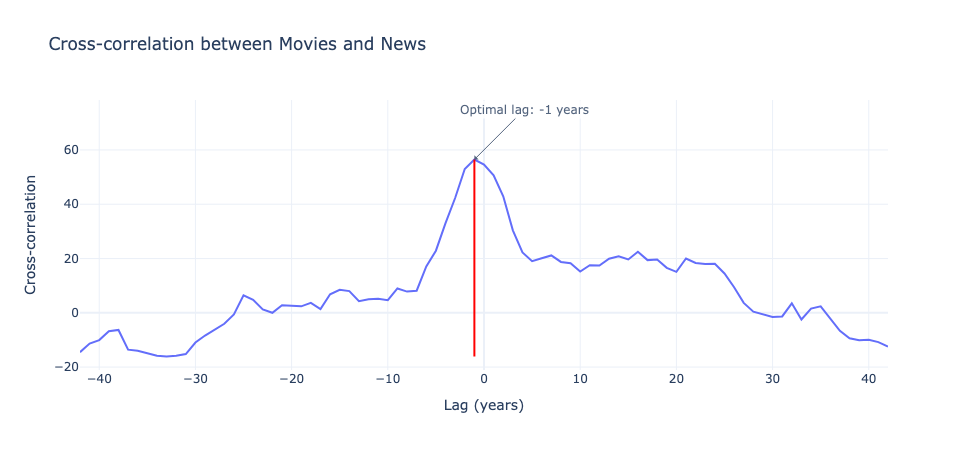

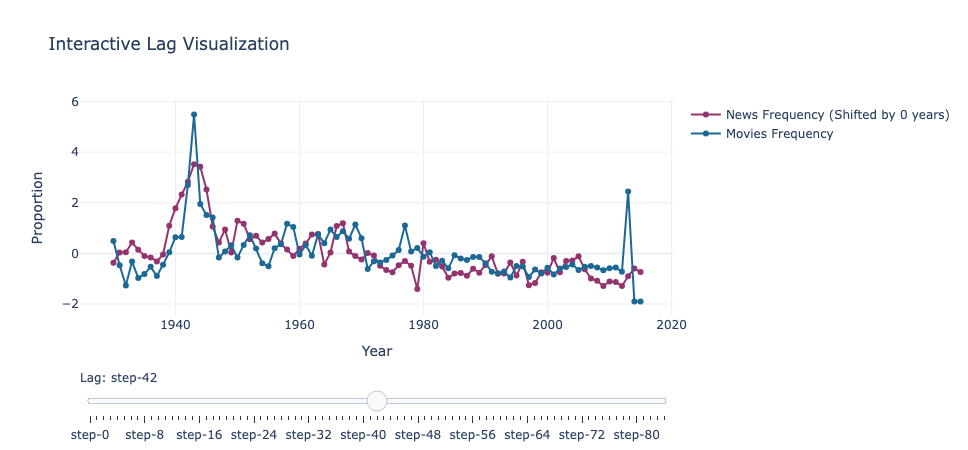

In [8]:
theme = 'World War II'
# This line is commented because we cannot show interactive plots on the HTML export.
#hta.plot_movies_and_news_frequency(theme, 'data/')
# We load saved versions of the interactive plots instead.
plot_1 = Image(filename='figures/saved_plots_results/cross-corr2.png')
plot_2 = Image(filename='figures/saved_plots_results/distrib-2.png')

display(plot_1)
display(plot_2)

This less surprising results shows that when the theme is a historical event, here World War II, the popularity of the theme in news and movies is, once again, strongly correlated. However, this correlation is the highest with (almost) no shift in time. Here, the movie production and the popularity in media is following similar evolution in real time.

# Movie Analysis

Now, let's analyse the themes in the movie dataset to understand how they impact the movies genres and sentiment. 

All these analyses can be found in the notebooks corresponding at the themes `src/sentiment_analysis/{theme}_Sentiment_Analysis`

We'll analyse here one theme to show the processus.

## Cold War

In [9]:
theme = "Cold War"
#First, load the dataset
df_plot = load_theme_dataset("movies_cold_war.csv", "data/df_movies/")

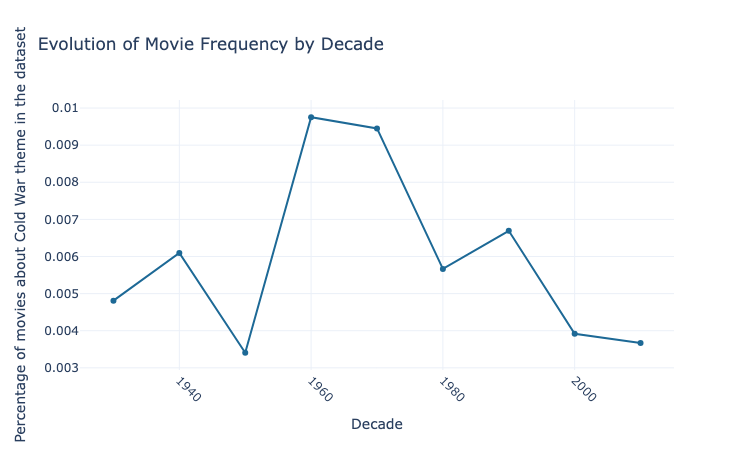

In [10]:
# This line is commented because we cannot show interactive plots on the HTML export.
# plot_movie_frequency(df_plot, theme, time_unit='Decade', data_folder='data/')

plot_1 = Image(filename='figures/saved_plots_results/cold_war_movie_frequency.png')
display(plot_1)

There are more films during the 1960s-1970s. Let's analyse that. By looking at the plot summary we can extract these main themes:
- Nuclear anxiety: accidental nuclear strikes, space races, and clashes between democracy and communism.
- War and Resistance: Stories about World War II and other conflicts dominate, showing the  resistance movements, espionage, and personal sacrifices during wartime.
- Political satire: Some movies use humor and satire to critique political ideologies, societal norms, which reflects Cold War propaganda or domestic issues.
- Technology: Themes around technological advancements, particularly in space exploration and military innovation, shows the fascination and fear associated with rapid scientific progress during the Cold War.
- Human relationship: a recurring theme is the resilience of human connections—family, friendship, and love—as a counterpoint to the larger conflicts.

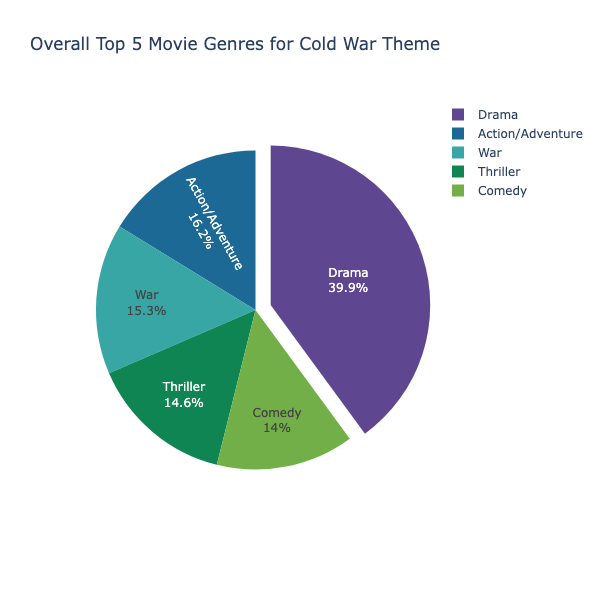

In [11]:
#plot_overall_top_genres(df_plot, theme, x=5)
plot_1 = Image(filename='figures/saved_plots_results/cold_war_overall_top_genres.png')
display(plot_1)

Top 5 movies genres:
- Drama: Shows messy conflicts and personal struggles of that time
- Action Adventure: Action, conflicts and tensions of that time
- War
- Thriller: Espionage, intrigues
- Comedy: satire, dark-humor

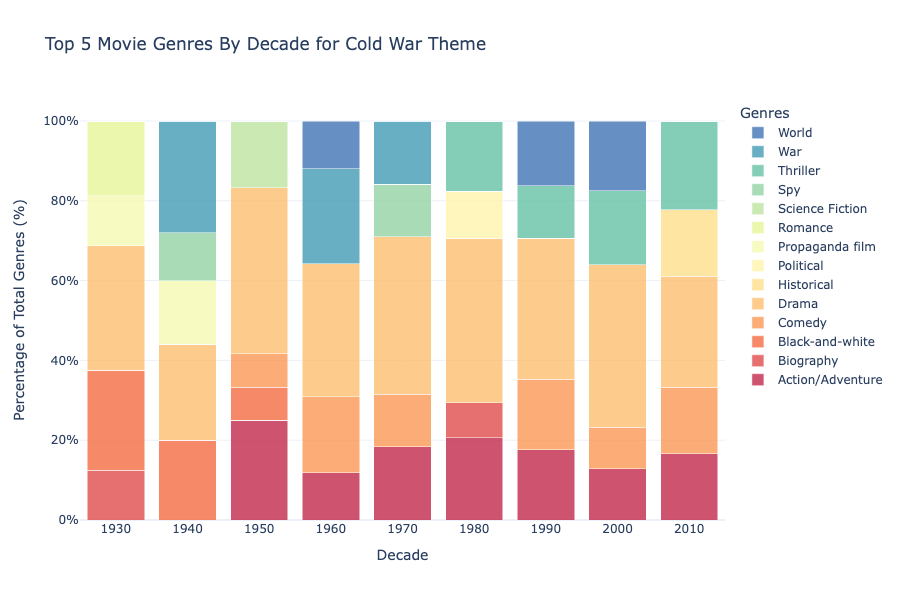

In [12]:
#plot_top_genres_by_decade(df_plot, theme, x=5)
plot_1 = Image(filename='figures/saved_plots_results/cold_war_top_genres_by_decade.png')
display(plot_1)

### 1940s

Interesting genres: War, Spy, Propaganda Film
These reflected the global conflict of World War II, with War films capturing battles and heroism, Spy films diving into espionage and secret missions, and Propaganda films promoting national unity and ideological messages. These genres mirrored the intense political and social atmosphere of the decade.

### 1950s

Interesting genres: Science-Fiction, Action-Adventure. Science Fiction explored fears of nuclear technology and the unknown, reflecting Cold War anxieties about the future and space exploration. Action/Adventure brought excitement with  heroes and quests to symbolise thhe ideoological battles of the era.

Here, we also looked in the NYT dataset to see if the news talked about nuclear: 
In the NYT dataset, we have 4466 news having the word "nuclear" during this period.

### 1960s
Interesting genres: Comedy, World. The World genre include a wide range of stories exploring global conflicts, historical events, and societal changes with main themes war and revolution, cold war and espionage and global perspectives. Comedy is used in a satire way to critique the societal norms It provides a lighter yet thought-provoking lens on pressing issues of the time

### 1970s
Interesting genres: War, Spy. These are the main years of the cold war. The War genre here explores those main themes: resistance, cultural identity, psychological cost of war and oppression, espionage... The Spy genre ahs thems such as paranoia, espionage and the high-stakes of world secrets and technological competition that defined East-West tensions.


In the NYT dataset, there are 2432 news related to the word "espionage" or "spy"

### 1980s
Interesting genres: Thriller, Political For the political genres, we can see American movies criticisng the Soviet through societal and political structures through allegory and personal stories. Also, we can find explorations of ideological conflicts, cultural divides, and individual struggles under oppressive system. For the thriller genres, we also see the paranoia through movies that have assassination attempts and shows the anxiety all oover the world.

### 1990s
Interesting genres: World. The world genre was dominated by narratives reflecting the geopolitical shifts following the Cold War, such as the dissolution of the Soviet Union, the Balkan wars, and post-communist transitions. We can also see the critiique of remaining ccommunist cvoruntries from the capitalists ones, 

### 2010s
Interesting genres: Historical. As the world moved further from the Cold War and the collapse of communism, filmmakers in post-Soviet and post-communist states revisited their histories with a point of view: exploring themes of identity, transformation, and reconciliation. We see thus a lot of movies related to cold war, even if it's done. 

## Geographical analysis

Let's analyse the countries related to the movies.

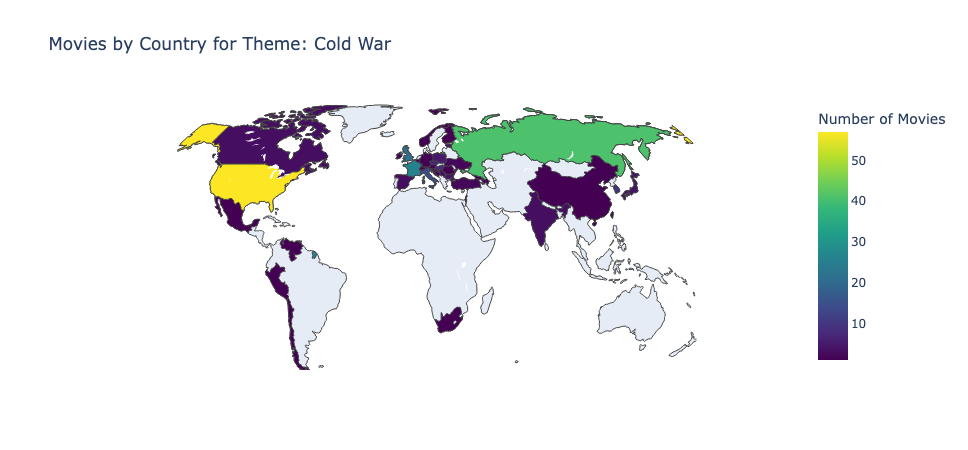

In [28]:
#plot_movie_countries_world_map(df_plot, theme)
plot_1 = Image(filename='figures/saved_plots_results/map.png')
display(plot_1)


With no surprise, the main countries talking about Cold War are the US and USSR. 

## Emotion Analysis

Now, let's analyse the emotion in those movies!

In [29]:
df_plot = create_emotions_column(df_plot)

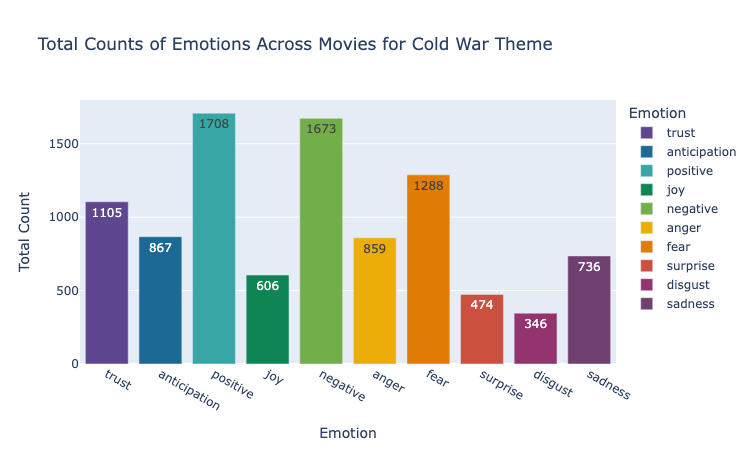

In [30]:
#plot_emotion_counts(df_plot, theme)
plot_1 = Image(filename='figures/saved_plots_results/cold_war_emotion_counts.png')
display(plot_1)

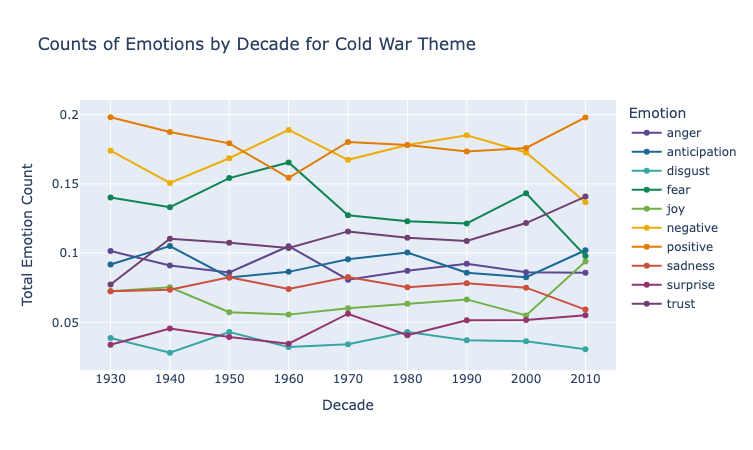

In [31]:
#plot_emotion_counts_by_decade(df_plot, theme)
plot_1 = Image(filename='figures/saved_plots_results/cold_war_emotion_counts_by_decade.png')
display(plot_1)

We see that there is less positive emotions during the Cold War. And there's a decrease of positive emotion from 1940s to 1960s. The American and Soviet Union were allies during WW2 showcasing the positive emootions during this period. But, then we see a decrease of positive emotions in the period of the Cold War.

Negative emotions like fear, sadness, and disgust are consistently prevalent, reflecting the Cold War's tension, uncertainty, and threats (e.g., nuclear warfare, espionage).
Fear shows a peak during the Cold War decades, particularly in the 1950s-1980s, corresponding to  tensions during events like the Cuban Missile Crisis. It declines in the 1990s and 2000s, aligning with the Cold War's end.
Trust is relatively low but stable, perhaps reflecting the theme of distrust intrinsic to espionage and ideological rivalry and increases towards th 1990s

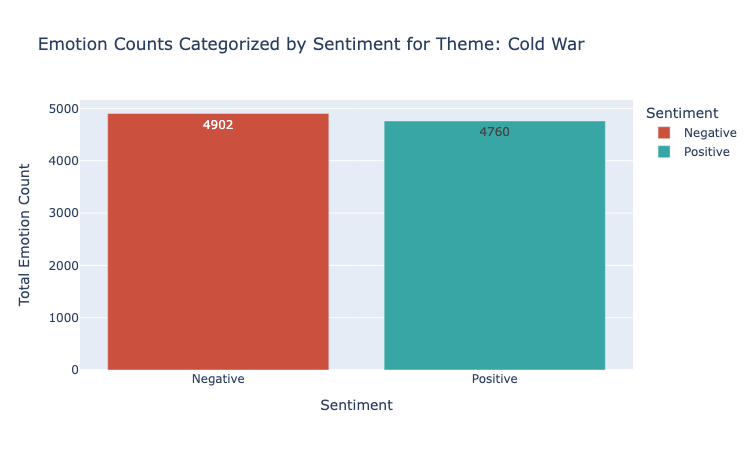

In [32]:
#plot_emotion_sentiment_counts(df_plot, theme)
plot_1 = Image(filename='figures/saved_plots_results/cold_war_emotion_sentiment_counts.png')
display(plot_1)

Here, the emotions are grouped into positive and negative sentiment. 

The counts for negative (4902) and positive (4760) sentiments are relatively close, indicating that Cold War narratives balance darker and more hopeful tones.
This balance reflects the duality of Cold War that shows fear, mistrust, and conflict alongside resilience, innovation, and eventual resolution.
The near-equal distribution suggests that Cold War narratives don't focus only on despair or triumph but instead explore the nuanced emotions of the era.


## Sentiment Analysis

Now, let's analyse the overall sentiment: positive or negative

In [33]:
df_plot = perform_sentiment_analysis(df_plot)

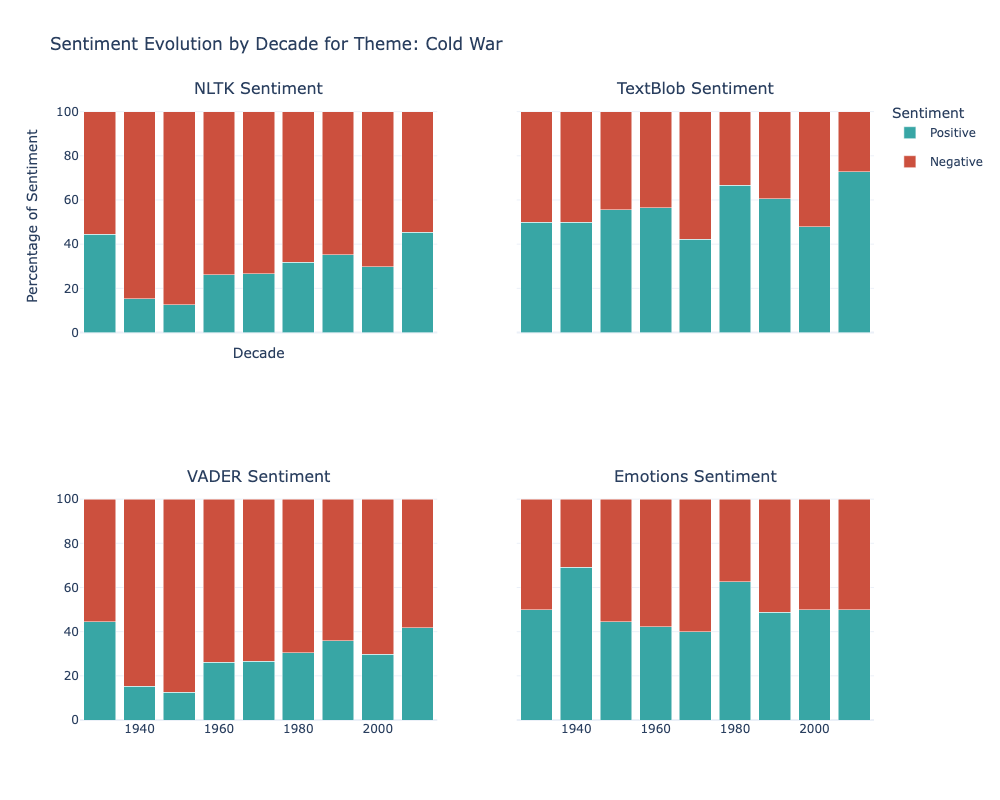

In [34]:
#plot_all_sentiments(df_plot, theme)
plot_1 = Image(filename='figures/saved_plots_results/cold_war_all_sentiments.png')
display(plot_1)

This plot shows the sentiment analysis by four algorithms: NLTK, Textblob, VADER, and the emotions sentiment grouped by positive and negative sentiment.

We see that negative emotion prevails, as expected when talking about wars.

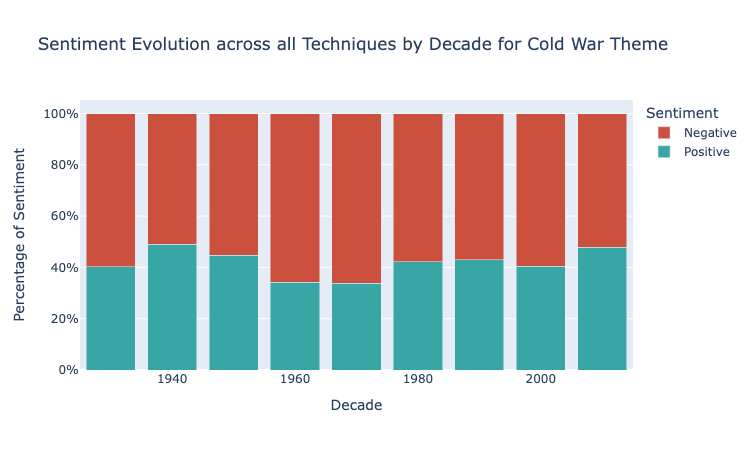

In [35]:
#plot_combined_sentiment_by_decade(df_plot, theme)
plot_1 = Image(filename='figures/saved_plots_results/cold_war_combined_sentiment_by_decade.png')
display(plot_1)

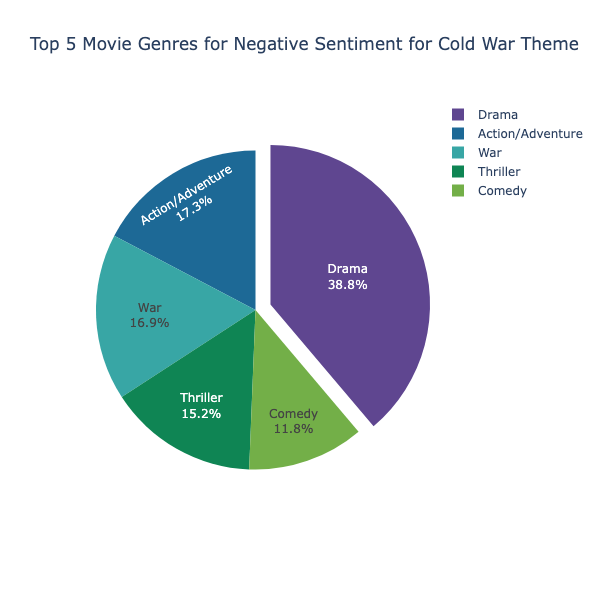

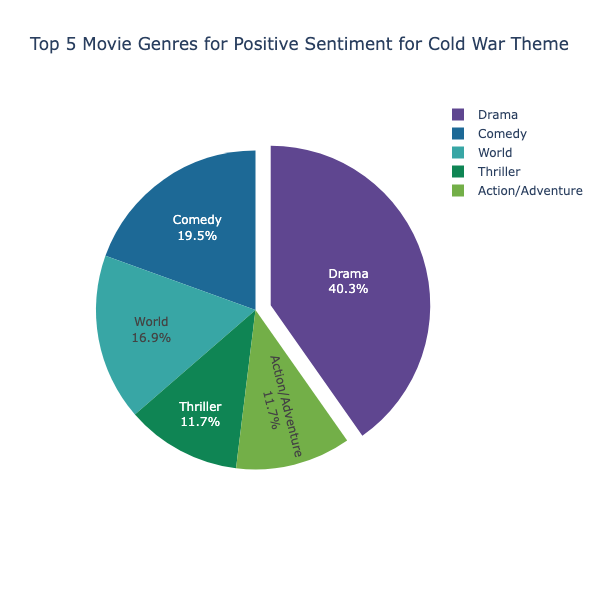

In [36]:
#fig = plot_top_movie_genres_by_sentiment(df_plot, theme, x=5)
#fig['negative'].show()
#fig['positive'].show()
plot_1 = Image(filename='figures/saved_plots_results/cold_war_top_movie_genres_by_sentiment_negative.png')
display(plot_1)
plot_2 = Image(filename='figures/saved_plots_results/cold_war_top_movie_genres_by_sentiment_positive.png')
display(plot_2)

What is interesting here:
- Negative sentiment: Comedy is prevalent because Cold War comedies often used satire to critique political ideologies, societal paranoia, and absurdities of the era. Used humour to show the darker truth of the era. 
- Positive sentiment: World. Many Cold War-themed world cinema narratives from the post-Cold War period focus on reconciliation. 

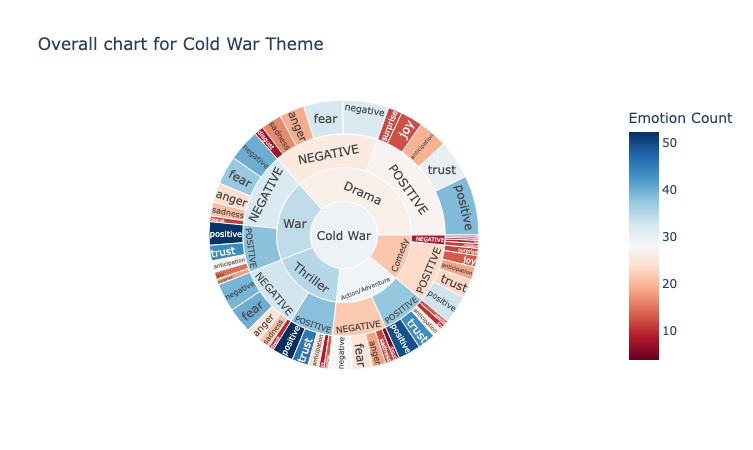

In [37]:
#plot_sunburst_genres_sentiment_emotions(df_plot, theme)
plot_1 = Image(filename='figures/saved_plots_results/cold_war_sunburst_genres_sentiment_emotions.png')
display(plot_1)

## Conclusion



The analysis shows how movies connect with their time, often reflecting key events and emotions from history. Films about war, espionage, and politics mirror the worries and struggles of their era.
The emotions and sentiments in Cold War-themed movies, while varied, often highlight the tension and anxiety of the period. This makes sense: it was a stressful time. In the end, movies don’t just tell stories; they capture the feelings and challenges of the people who lived through those moments, helping us understand the past on a deeper level. 